<a href="https://colab.research.google.com/github/debg48/pytorch_for_beginners/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Data and Preprocessing

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
val_size = 5000
train_size = len(dataset)-val_size
train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [7]:
len(train_ds)

55000

In [8]:
batch_size = 128

In [9]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 1, 28, 28])


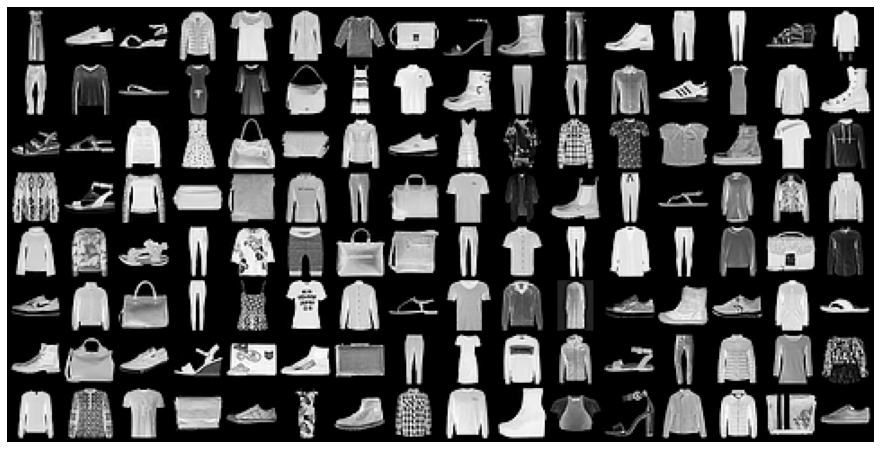

In [10]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

#Defining Model

In [11]:
class MnistModel(nn.Module):

  # Feed Forward network (16,32,10) 

  def __init__(self,in_size,out_size):
      super().__init__()
      #layer 1
      self.linear1=nn.Linear(in_size,16)
      #layer2
      self.linear2=nn.Linear(16,32)
      #layer3
      self.linear3=nn.Linear(32,out_size)

  # forward prop

  def forward(self,xb):
    xb=xb.view(xb.size(0),-1)
    out=self.linear1(xb)
    out= F.relu(out)
    out=self.linear2(out)
    out = F.relu(out)
    out =self.linear3(out)
    return out

  def training_step(self, batch):
      images, labels = batch 
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      return loss
  
  def validation_step(self, batch):
      images, labels = batch 
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss, 'val_acc': acc}
      
  def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
      return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
      print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
  

In [12]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
input_size = 784
num_classes = 10

In [14]:
model = MnistModel(input_size, out_size=num_classes)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'val_loss': 2.314784526824951, 'val_acc': 0.10163142532110214}]

In [17]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6095, val_acc: 0.7872
Epoch [1], val_loss: 0.5239, val_acc: 0.8056
Epoch [2], val_loss: 0.4666, val_acc: 0.8370
Epoch [3], val_loss: 0.4271, val_acc: 0.8482
Epoch [4], val_loss: 0.4143, val_acc: 0.8475


In [18]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3879, val_acc: 0.8600
Epoch [1], val_loss: 0.3864, val_acc: 0.8609
Epoch [2], val_loss: 0.3855, val_acc: 0.8623
Epoch [3], val_loss: 0.3852, val_acc: 0.8607
Epoch [4], val_loss: 0.3848, val_acc: 0.8617
Epoch [5], val_loss: 0.3844, val_acc: 0.8617
Epoch [6], val_loss: 0.3841, val_acc: 0.8619
Epoch [7], val_loss: 0.3840, val_acc: 0.8617
Epoch [8], val_loss: 0.3840, val_acc: 0.8607
Epoch [9], val_loss: 0.3838, val_acc: 0.8605
